## <center> Part 1 ‐ Exploratory data analysis

### 1.Importing Necessary Libraries

In [87]:
import json
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
import pylab
import numpy as np
import matplotlib.style as style 
style.use('ggplot')

In [88]:
%matplotlib notebook

### 2. Reading Data

**Note:** The `logins` data contains timestamps over a period of over three months starting from January through mid-April.

In [89]:
logins = pd.read_json('logins.json')

In [90]:
type(logins)

pandas.core.frame.DataFrame

In [5]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [6]:
logins.head()

login_time
0 1970-01-01 20:13:18
1 1970-01-01 20:16:10
2 1970-01-01 20:16:37
3 1970-01-01 20:16:36
4 1970-01-01 20:26:21

### 3. Data Inspection

In [53]:
logins.describe()

login_time
count                 93142
unique                92265
top     1970-02-12 11:16:53
freq                      3
first   1970-01-01 20:12:16
last    1970-04-13 18:57:38

**Note:** Surprisingly, there are duplicates in `login_time`. This is unlikely since the probability of two users logging in at the same time (timestamp value) is very low.

In [39]:
logins.isnull().sum()

login_time    0
dtype: int64

### 4. Exploratory Data Analysis

**Visulaize timestamps in 15 minutes intervals:**

In [7]:
%matplotlib inline

In [8]:
#Set some global plot defaults
sns.set(rc={"figure.figsize": (18, 6), 'legend.fontsize': 18}) # figsize and leg fontsize of seaborn plots
plt.rc('axes' , labelsize=18)                                  # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)                                  # fontsize of the tick labels
plt.rc('ytick', labelsize=18)                                  # fontsize of the tick labels
plt.rc('axes' , titlesize=18)                                  # fontsize of the plot title

In [9]:
logins.set_index('login_time', inplace = True)
logins['login'] = 1

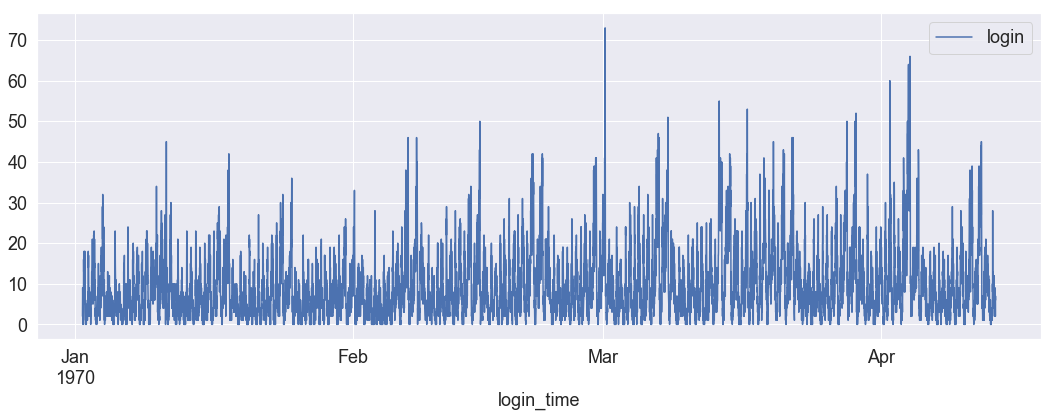

In [60]:
logins.resample('15T').sum().plot()
plt.show()

In [10]:
import statsmodels.api as sm

In [11]:
from collections import defaultdict
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier

C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


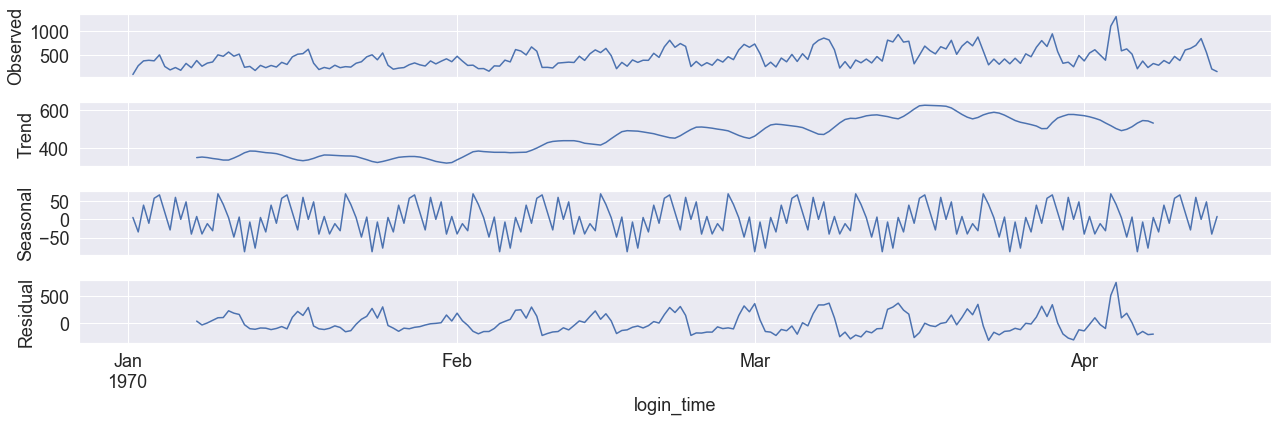

In [63]:
decomposition = sm.tsa.seasonal_decompose(logins.resample('12H').sum())
decomposition.plot()
plt.show()

**Note:** We see the spikes and dips throughout the timeframe. However, to draw proper inclusions, we need to have a closer look. 

- Day level 
- Week level

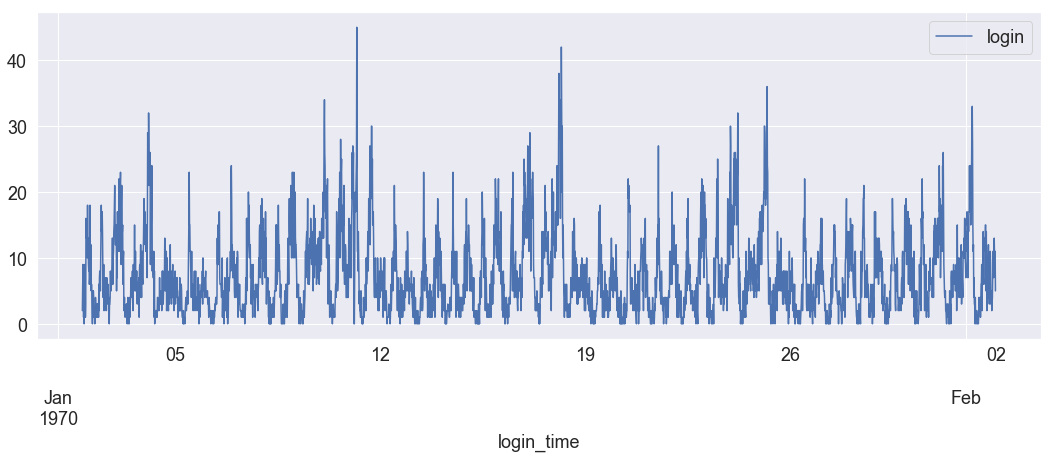

In [64]:
logins.resample('15T').sum()['1970-01-01':'1970-02-01'].plot()
plt.show()

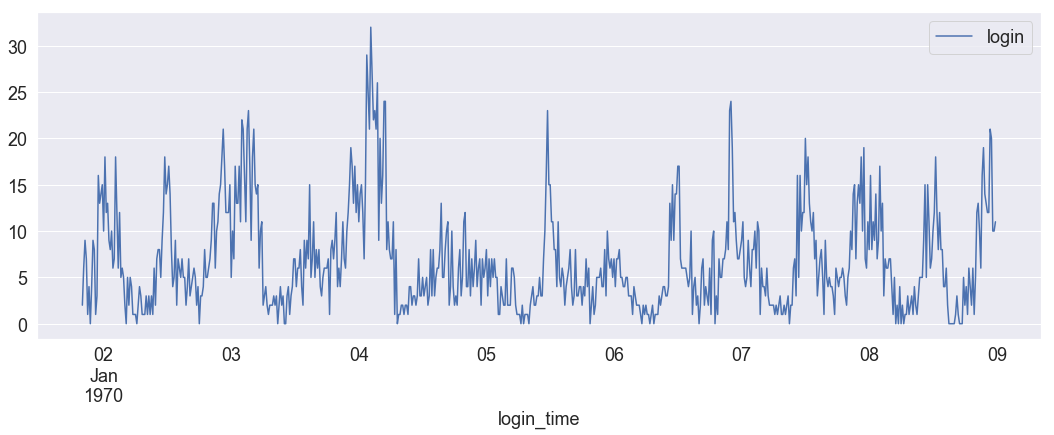

In [65]:
logins.resample('15T').sum()['1970-01-01':'1970-01-08'].plot()
plt.show()

**Note:** Looking at the above graphs, we see that there is some kind of pattern at daily level. Though it is not definite, there surely some pattern.

**Interpretation:** The follwoing conclusions can be drawn from the above graphs.

1. The activity generally peaks twice in a day (approximately every 12 hours - early morning and early afternoon). 
2. Activity generally builds over the course of the week, peaking on the weekend.

## <center> Part 2 ‐ Experiment and metrics design

**Background:** The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two-way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?  

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **Answer:** For a single KPI, a measure of the ratio of activity of a driver in the other city. For example, assume driver A from Gotham drove 100 times. Only 5 of them were in Metropolis. Driver A's ratio is then 5%. Currently, drivers in both cities have high ratios towards their primary city. Ultimate would like to move these ratios towards 50% so that the drivers are closer to evenly distributed: driving in both cities. This metric would show the experiment working or not working reasonably well. 

2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

    1. how you will implement the experiment
    2. what statistical test(s) you will conduct to verify the significance of the observation
    3. how you would interpret the results and provide recommendations to the city operations team along with any caveats.  
    
    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **Answer:** We can assume data is always being collected. Thus we can measure our KPI before our experiment actually begins. It is important to know these numbers before the experiment starts, since that is what we will be comparing to. In some sense, this can be thought of as an A/B test, so we need to know the data very well before the change. Further, we also need to make sure we don't bias or pollute the data by announcing the experiment or change too prematurely. We don't want upcoming news to change behavior making it difficult for us to determine the results of the experiment. 

Then we can announce the change and begin the toll reimbursement program. We would then start monitoring the new data. We would have to run the experiment for at least some amount of time. This could be a week or a month. It depends entirely on the scale of the data involved. We would use a statistical power test to estimate the data required to be able to discern any statistical significance. Then we could run a two-tailed $z$-test comparing sample proportions (since that is what the ratio is). This would give us a $z$-score and associated $p$-value. A low $p$-value (say at $\alpha$=0.01) would potentially indicate a significant change in our KPI (good or bad). We could further calculate the confidence intervals for this to be able to strongly claim a statistical change in the KPI, if it exists.

Assuming our KPI does change, and in a positive direction, then we still have to be mindful of the results. We could see positive change, where more drivers are now in the city other than their primary. However, we have to estimate the amount of revenue that exact change has brought and compare it to the cost of the program (remember Ultimate is paying the tolls!). A positive KPI change coupled with negative revenue is perhaps not the ideal. We also mentioned that while the program can result in a statistical change in the KPI, it could lead to worse results. So the analysts need to be aware of this fact as well. Further, this ratio metric is time agnostic, ignoring weekdays, weekends, day or night. A further iteration of this analysis would also include this (by perhaps binning in time) to see if perhaps there are certain times when the program is being used more than others. 

## Part 3
Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its longterm
rider retention (again, a few sentences will suffice).

### Part 3.1

We start of course by loading and then briefly exploring the data. 

### 1. Reading Data

In [91]:
# Read json file
with open('ultimate_data_challenge.json') as file:
    ultimate = json.load(file)

In [92]:
# Convert json object to dataframe
ultimate = pd.DataFrame(ultimate)

In [14]:
ultimate.head(2)

avg_dist  avg_rating_by_driver  avg_rating_of_driver  avg_surge  \
0      3.67                   5.0                   4.7        1.1   
1      8.26                   5.0                   5.0        1.0   

             city last_trip_date    phone signup_date  surge_pct  \
0  King's Landing     2014-06-17   iPhone  2014-01-25       15.4   
1         Astapor     2014-05-05  Android  2014-01-29        0.0   

   trips_in_first_30_days  ultimate_black_user  weekday_pct  
0                       4                 True         46.2  
1                       0                False         50.0

### 2. Data Inspection

In [72]:
ultimate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [73]:
ultimate.describe()

avg_dist  avg_rating_by_driver  avg_rating_of_driver     avg_surge  \
count  50000.000000          49799.000000          41878.000000  50000.000000   
mean       5.796827              4.778158              4.601559      1.074764   
std        5.707357              0.446652              0.617338      0.222336   
min        0.000000              1.000000              1.000000      1.000000   
25%        2.420000              4.700000              4.300000      1.000000   
50%        3.880000              5.000000              4.900000      1.000000   
75%        6.940000              5.000000              5.000000      1.050000   
max      160.960000              5.000000              5.000000      8.000000   

          surge_pct  trips_in_first_30_days   weekday_pct  
count  50000.000000            50000.000000  50000.000000  
mean       8.849536                2.278200     60.926084  
std       19.958811                3.792684     37.081503  
min        0.000000                0.000000      0.000000  
25%        0.000000                0.000000     33.300000  
50%        0.000000                1.000000     66.700000  
75%        8.600000                3.000000    100.000000  
max      100.000000              125.000000    100.000000

In [74]:
# Checking for null values
ultimate.isnull().sum()

avg_dist                     0
avg_rating_by_driver       201
avg_rating_of_driver      8122
avg_surge                    0
city                         0
last_trip_date               0
phone                      396
signup_date                  0
surge_pct                    0
trips_in_first_30_days       0
ultimate_black_user          0
weekday_pct                  0
dtype: int64

In [75]:
# Datatype Check
ultimate.dtypes

avg_dist                  float64
avg_rating_by_driver      float64
avg_rating_of_driver      float64
avg_surge                 float64
city                       object
last_trip_date             object
phone                      object
signup_date                object
surge_pct                 float64
trips_in_first_30_days      int64
ultimate_black_user          bool
weekday_pct               float64
dtype: object

**Note:** From the above analysis, it is evident that there are null values in few columns; and, the datatype of `last_trip_date` and `signup_date` is <u>object</u> instead of <u>Datetime</u>

In [93]:
# Convert the time series to datetimes appropriately
ultimate['last_trip_date'] = pd.to_datetime(ultimate['last_trip_date'])
ultimate['signup_date'] = pd.to_datetime(ultimate['signup_date'])

In [16]:
type(ultimate['last_trip_date'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [17]:
type(ultimate['signup_date'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [18]:
ultimate[['signup_date', 'last_trip_date']].describe()

signup_date       last_trip_date
count                 50000                50000
unique                   31                  182
top     2014-01-18 00:00:00  2014-06-29 00:00:00
freq                   2948                 2036
first   2014-01-01 00:00:00  2014-01-01 00:00:00
last    2014-01-31 00:00:00  2014-07-01 00:00:00

### 4. EDA on Categorical Data

In [19]:
#Set some global plot defaults
sns.set(rc={"figure.figsize": (9, 6), 'legend.fontsize': 18}) # figsize and leg fontsize of seaborn plots
plt.rc('axes' , labelsize=8)                                  # fontsize of the x and y labels
plt.rc('xtick', labelsize=8)                                  # fontsize of the tick labels
plt.rc('ytick', labelsize=8)                                  # fontsize of the tick labels
plt.rc('axes' , titlesize=8)                                  # fontsize of the plot title

In [20]:
ultimate['city'].value_counts()

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

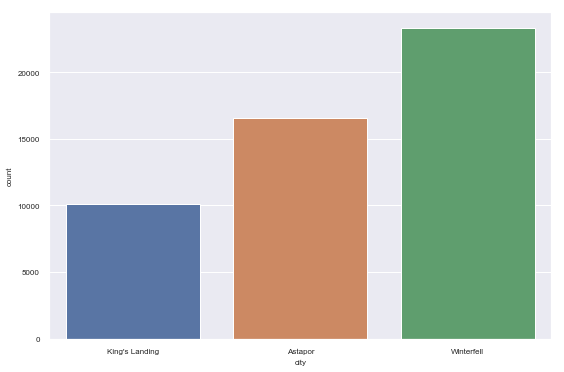

In [81]:
sns.countplot(ultimate['city'])

In [18]:
ultimate['phone'].value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

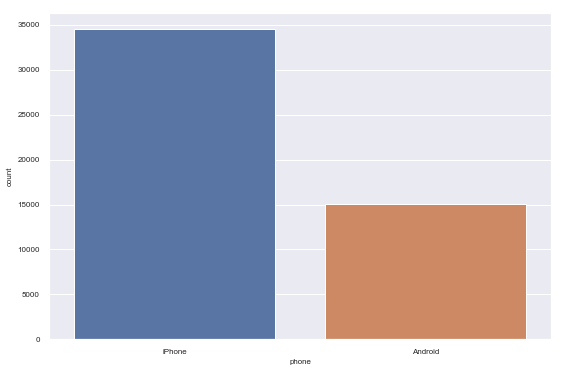

In [82]:
sns.countplot(ultimate['phone'])

### 4. EDA on Numerical Data

**`avg_dist`:**

(array([4.7232e+04, 2.4750e+03, 2.4400e+02, 3.9000e+01, 8.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  0.   ,  16.096,  32.192,  48.288,  64.384,  80.48 ,  96.576,
        112.672, 128.768, 144.864, 160.96 ]),
 <a list of 10 Patch objects>)

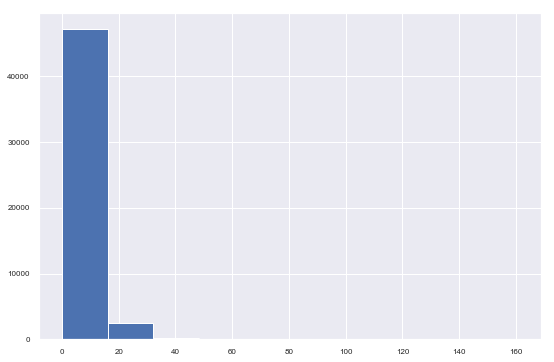

In [83]:
plt.hist(ultimate['avg_dist'])

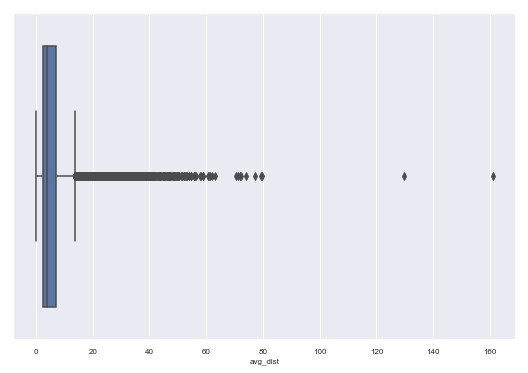

In [86]:
sns.boxplot(ultimate['avg_dist']).

**`avg_rating_by_driver`:**

(array([1.8100e+02, 4.0000e+00, 1.2600e+02, 3.2000e+01, 5.0000e+00,
        6.5600e+02, 5.2400e+02, 2.0800e+03, 4.6440e+03, 4.1547e+04]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

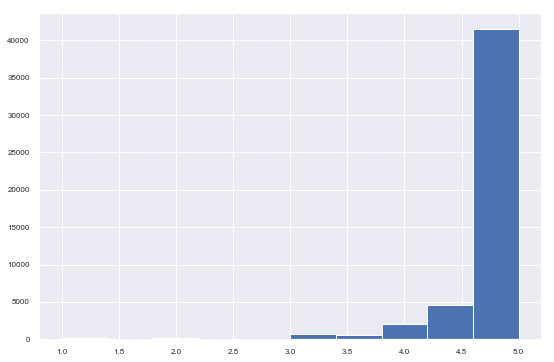

In [89]:
pylab.hist(udc_dff['avg_rating_by_driver'][~np.isnan(udc_dff['avg_rating_by_driver'])])

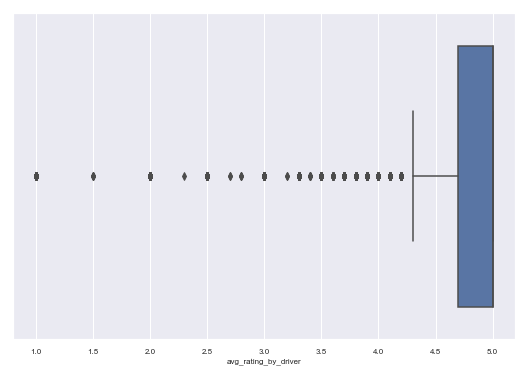

In [91]:
sns.boxplot(ultimate['avg_rating_by_driver'])

**`avg_rating_of_driver`:**

(array([2.560e+02, 7.000e+00, 2.180e+02, 1.200e+02, 1.000e+02, 1.404e+03,
        1.452e+03, 4.846e+03, 5.415e+03, 2.806e+04]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

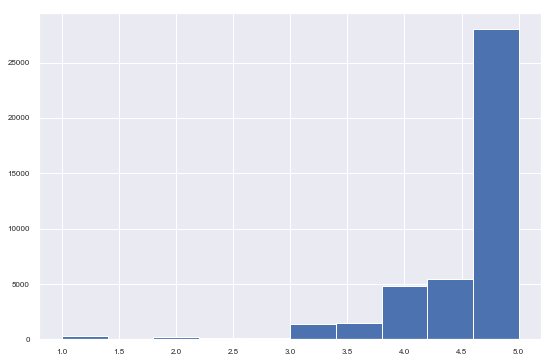

In [94]:
pylab.hist(udc_dff['avg_rating_of_driver'][~np.isnan(udc_dff['avg_rating_of_driver'])])

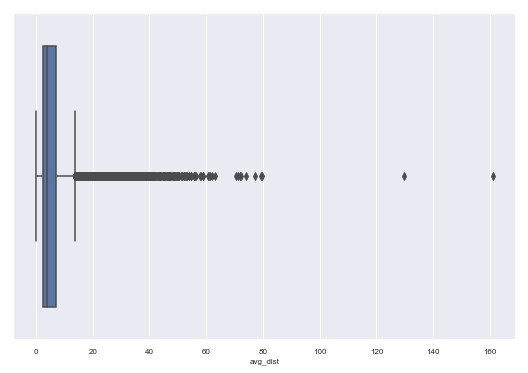

In [86]:
sns.boxplot(ultimate['avg_dist']).

**`avg_surge`:**

(array([4.8841e+04, 8.5800e+02, 2.3400e+02, 3.8000e+01, 1.7000e+01,
        1.0000e+01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1. , 1.7, 2.4, 3.1, 3.8, 4.5, 5.2, 5.9, 6.6, 7.3, 8. ]),
 <a list of 10 Patch objects>)

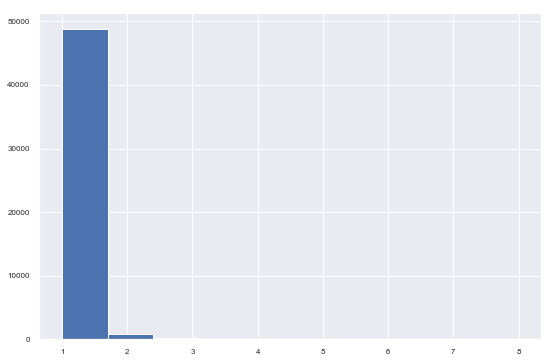

In [95]:
plt.hist(ultimate['avg_surge'])

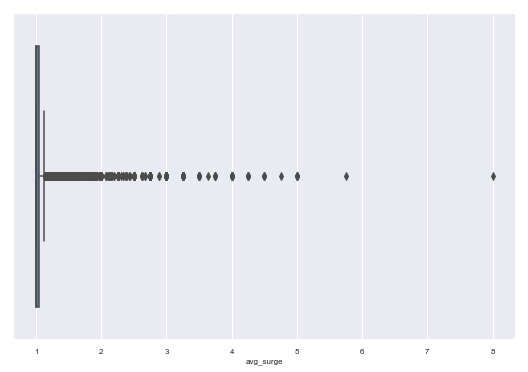

In [97]:
sns.boxplot(ultimate['avg_surge'])

**`surge_pct`:**

(array([3.8048e+04, 4.1320e+03, 2.8500e+03, 1.5250e+03, 3.5400e+02,
        1.4050e+03, 2.1500e+02, 3.9000e+01, 1.6000e+01, 1.4160e+03]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <a list of 10 Patch objects>)

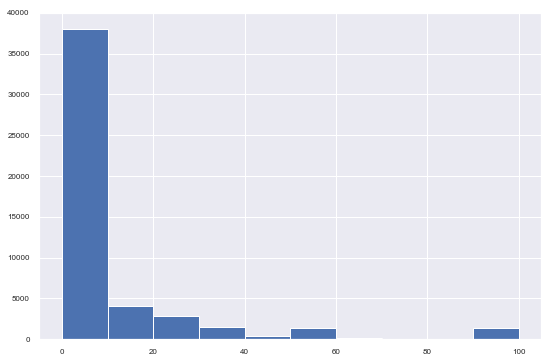

In [98]:
plt.hist(ultimate['surge_pct'])

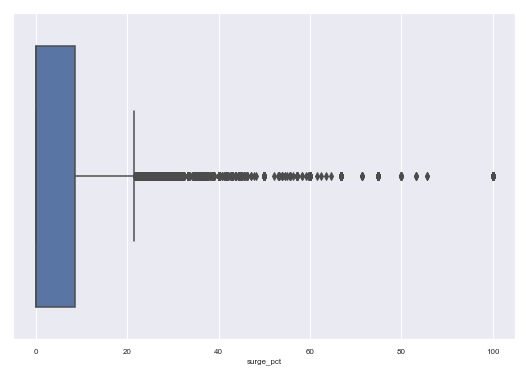

In [100]:
sns.boxplot(ultimate['surge_pct'])

**`trips_in_first_30_days`:**

(array([4.875e+04, 1.043e+03, 1.600e+02, 3.200e+01, 1.100e+01, 3.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([  0. ,  12.5,  25. ,  37.5,  50. ,  62.5,  75. ,  87.5, 100. ,
        112.5, 125. ]),
 <a list of 10 Patch objects>)

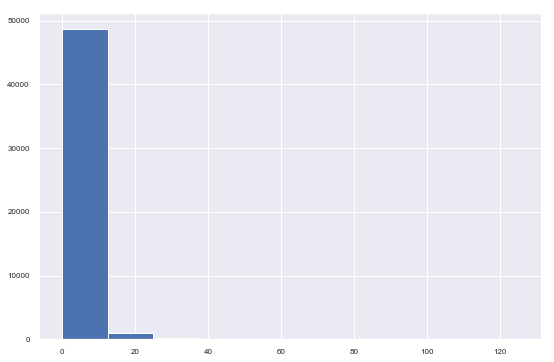

In [101]:
plt.hist(ultimate['trips_in_first_30_days'])

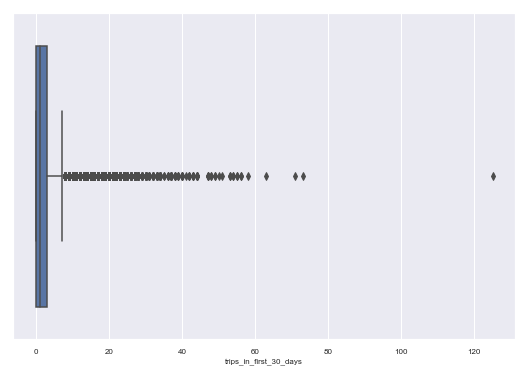

In [103]:
sns.boxplot(ultimate['trips_in_first_30_days'])

**`ultimate_black_user`:**

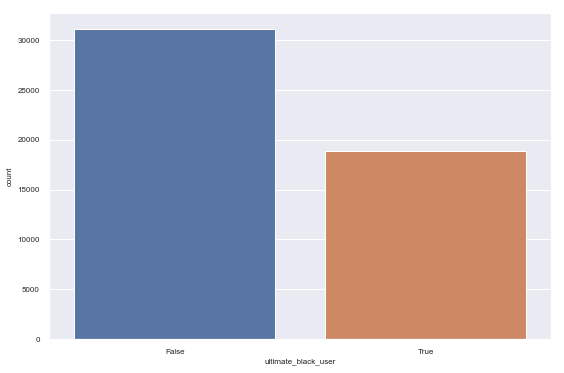

In [110]:
sns.countplot(ultimate['ultimate_black_user'])

**Note:** Most of the above plots are heavily skewed (positively or negatively) which is due to the presence of large amount of outliers.

Its a good idea to remove extreme values i.e. +-4 standard deviations from the mean.

### 5. Data Pre-Processing

In [77]:
ultimate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
is_active                 50000 non-null bool
city_Astapor              50000 non-null uint8
city_King's Landing       50000 non-null uint8
city_Winterfell           50000 non-null uint8
phone_Android             50000 non-null uint8
phone_iPhone              50000 non-null uint8
dtypes: bool(2), float64(6), int64(1), uint8(5)
memory usage: 3.0 MB


In [106]:
ultimate.dropna(inplace = True)
ultimate.reset_index(drop = True, inplace = True)

In [79]:
ultimate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41744 entries, 0 to 41743
Data columns (total 14 columns):
avg_dist                  41744 non-null float64
avg_rating_by_driver      41744 non-null float64
avg_rating_of_driver      41744 non-null float64
avg_surge                 41744 non-null float64
surge_pct                 41744 non-null float64
trips_in_first_30_days    41744 non-null int64
ultimate_black_user       41744 non-null bool
weekday_pct               41744 non-null float64
is_active                 41744 non-null bool
city_Astapor              41744 non-null uint8
city_King's Landing       41744 non-null uint8
city_Winterfell           41744 non-null uint8
phone_Android             41744 non-null uint8
phone_iPhone              41744 non-null uint8
dtypes: bool(2), float64(6), int64(1), uint8(5)
memory usage: 2.5 MB


### 6. Machine Learning

In [95]:
active_dict = {x:False for x in range(0, len(ultimate))}

In [96]:
active_dict[0]

False

In [97]:
#Loop over rows
for i in range(len(ultimate)):
    start = ultimate['signup_date'][i]                   #Set the start date of this row
    end = start + pd.Timedelta('181D')                   #Set the end date for this row: 6 months later
    previous = end - pd.Timedelta('30D')                 #Set the time window, a month before end date
    if previous <= ultimate['last_trip_date'][i] <= end: #Was the last trip within the last month?
        active_dict[i] = True

In [98]:
#What is the percentage of active users?
num_active = np.sum(active_dict.values())

In [99]:
np.sum(list(num_active))

11236

In [100]:
# Create a new column 'is_active'
ultimate['is_active'] = pd.DataFrame(list(active_dict.items()), columns=['ind', 'active'])['active']

In [101]:
# Drop unwanted columns
ultimate.drop(['last_trip_date', 'signup_date'], axis=1, inplace=True)

In [102]:
# Get dummy variables for categorical columns
ultimate = pd.get_dummies(ultimate, drop_first=False)

In [103]:
ultimate.columns

Index(['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
       'surge_pct', 'trips_in_first_30_days', 'ultimate_black_user',
       'weekday_pct', 'is_active', 'city_Astapor', 'city_King's Landing',
       'city_Winterfell', 'phone_Android', 'phone_iPhone'],
      dtype='object')

In [109]:
# Extract values for the data
x = ultimate.drop('is_active', axis=1).values
y = ultimate['is_active'].values

# Get the column names for 'x'
df_columns = ultimate.drop('is_active', axis=1).columns.values

In [112]:
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42, stratify = y)

Likewise, we will setup a stratified kfold strategy for our cross-validated scoring that we will do. 

In [113]:
the_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1220)

**ROC:** ROC Area Under the Curve metric to compare our models. It is much better than accuracy since we have an imbalanced dataset. Further, it works very well for classification problems, since it takes both the true positive rate and false positive rate and distills it into one value. 

In [114]:
score_func = make_scorer(roc_auc_score, greater_is_better=True)

**Random Forest:** Random Forest is chosen over Logistic Regression since the latter is more simplistic and the latter also provides a ranking to determine the best features. 

**Cross Validation:** A 5-fold Cross Validation is performed to find the optimum parameters. 

In [115]:
#Setup the RF object
rf = RandomForestClassifier(criterion='gini', class_weight='balanced', n_jobs=-1)

#Hyperparameter grid
param_grid = {'n_estimators' : [40, 50, 60], 'min_samples_split' : [2, 3, 4], 
              'max_depth' : [4, 7, 10]}

#Setup the Gridsearch
rf_cv = GridSearchCV(rf, param_grid, cv=the_cv, scoring=score_func, verbose=1)

#Fit the data
rf_cv.fit(x_train, y_train)

#Print out the best model
print('Best RF Params: {}'.format(rf_cv.best_params_))
print('Best RF Score : %f' % rf_cv.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:  2.3min finished


Best RF Params: {'max_depth': 7, 'min_samples_split': 4, 'n_estimators': 60}
Best RF Score : 0.735569


**Best Parameters:** Using best parameters, to re-fit another Random Forest object. 

In [116]:
rf_best = RandomForestClassifier(criterion='gini', class_weight='balanced', n_jobs=-1, 
                                 n_estimators=rf_cv.best_params_['n_estimators'],
                                 min_samples_split=rf_cv.best_params_['min_samples_split'], 
                                 max_depth=rf_cv.best_params_['max_depth'])

rf_best.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=7, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=4, min_weight_fraction_leaf=0.0,
            n_estimators=60, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

Now, we can find the score in the test dataset. 

In [117]:
#Print the score/metric for the input model which must be fit
def get_scores(model, name='unk', score=roc_auc_score):
    
    #Make prediction for the model
    pred = model.predict(x_test)
    pred_prob = model.predict_proba(x_test)[:,1]

    #Calculate the score on the entire test set
    auc = score(y_test, pred_prob)
    
    #Calculate the score on CV test set
    cv_scores = cross_val_score(model, x_test, y_test, cv=the_cv, scoring=score_func)
    mean_cv = cv_scores.mean()
    std_cv = cv_scores.std()
    
    #Save to dataframe to be used for printing only
    model_score = pd.DataFrame(columns=['Model', 'Test score', 'CV score'])
    model_score.loc[0] = [name, auc, mean_cv]
    model_score.set_index('Model', inplace=True)
    print(model_score)

In [118]:
get_scores(rf_best, 'RF')

       Test score  CV score
Model                      
RF       0.807612  0.731897


In [126]:
pd.DataFrame(list(zip(df_columns, rf_best.feature_importances_)), columns=['Feature','Value']).\
   sort_values('Value', ascending=False).reset_index(drop=True)

Feature     Value
0                surge_pct  0.181408
1     avg_rating_by_driver  0.181351
2              weekday_pct  0.145171
3                avg_surge  0.106597
4      city_King's Landing  0.079280
5             phone_iPhone  0.059502
6            phone_Android  0.047611
7     avg_rating_of_driver  0.043897
8   trips_in_first_30_days  0.041975
9      ultimate_black_user  0.040805
10            city_Astapor  0.036352
11                avg_dist  0.026191
12         city_Winterfell  0.009860

**Interpretation:**

From the above table, we see that `surge_pct` and `avg_rating_by_driver` are the two most important predictors. 

- Practically this seems valid, since a high `surge_pct` means a better service. When combined with `avg_rating_by_driver`, higher  usage by the users. 

- It means users who also use Ultimate during the weekend, tend to use it all the time, thereby increasing their chances of being retained. 

- Aditionally, Ultimate can take extra measures in their marketing strategies in cities <bold> Astapor </bold> and <bold> Winterfell </bold>. The additional measures could be either improving the ride efficiency in the area, or requesting drivers to be more friendly with the passengers. 